# Fashion MNIST
---

This notebook aims to classify clothing images by utilizing Neural Networks architectures.

In [ ]:
!pip install scikeras[tensorflow]

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scikeras.wrappers import KerasClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data Preprocessing & Exploration
---

The MNIST fashion dataset is directly available from `tensorflow.keras.datasets`:

In [ ]:
# getting the data
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

The dataset consists of *10* classes. These are denoted as integers, *0-9*. Following the respective [Tensorflow documentation](https://www.tensorflow.org/tutorials/keras/classification) we assign these classes to their names:

In [ ]:
# denoting class names
class_names = [
    'T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'
]

Fore reference, we visualize once each different clothing class:

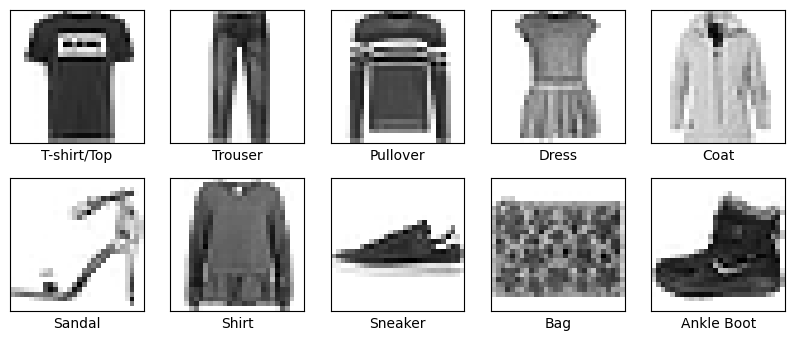

In [ ]:
# visualizing the classes
plt.figure(figsize=(10, 4))
for i in range(10):
    # get the index of the not-yet visualized class
    index = np.where(train_labels == i)[0][0]
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(
      train_images[index],
      cmap=plt.cm.binary
    )
    plt.xlabel(class_names[train_labels[index]])
plt.show()

Our images are given in grayscale format. We will standarize our dataset by dividing by *255*:

In [ ]:
# normalization
train_images = train_images / 255.0
test_images = test_images / 255.0

We then move on to the creation of the validation set:

In [ ]:
# train and validation set
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

The last step of the preprocessing is to transform zero-dimensional vectors to one dimensional, since this is needed for the training of the models we are going to follow:

In [ ]:
# transforming (n, ) vectors to (n, 1) => needed for the training of the models
train_labels = train_labels.reshape((-1, 1))
val_labels = val_labels.reshape((-1, 1))
test_labels = test_labels.reshape((-1, 1))

The final distribution of our train, validation and test sets are:

In [ ]:
print('Train:       X=%s, y=%s' % (train_images.shape, train_labels.shape))
print('Validation:  X=%s, y=%s' % (val_images.shape, val_labels.shape))
print('Test:        X=%s, y=%s' % (test_images.shape, test_labels.shape))

Train:       X=(48000, 28, 28), y=(48000, 1)
Validation:  X=(12000, 28, 28), y=(12000, 1)
Test:        X=(10000, 28, 28), y=(10000, 1)


## Data Pipeline
---

Before proceeding to the model architectures we followed for the given dataset, we will first create certain functions that will optimize our training. These utilize the `tensorflow.keras.Dataset` package.

In [ ]:
def _input_fn(x, y, BATCH_SIZE):

  """
    Receives x and y data and transforms them in PrefetchDataset objects.
    The data is shuffled and batched in the specified size.
    tf.data.experimental.AUTOTUNE is used for calculating the size of prefetched data at runtime according to resource heuristics.

    PARAMETERS
        @ X: X training numpy array
        @ y: y training numpy array
        @ BATCH_SIZE: int corresponding to the training batch size

    RETURNS
        PrefetchedDataset object dataset
  """

  ds = tf.data.Dataset.from_tensor_slices((x, y))
  ds = ds.shuffle(buffer_size=len(train_images))
  ds = ds.repeat() # repeat indefinately
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

The `_input_fn` function prepares the data for training. It utilizes the `shuffle`, `repeat` and `batch` methods creating batches that were randomly selected from the training set. Notice how the `repeat` method duplicates the dataset indefinately, enabling the `batch` method to generate training batches without any errors.

The function receives the images and labels and returns `PrefetchDataset` objects. These are Tensorflow objects that enable faster training, since the model can read the next-to-train batch of data while training the current batch. The batch size corresponds to the number of images that will flow through the network before a back-propagation operation, and hence a fine-tuning of the weights, takes place.

Since batch size [can significantly alter](https://www.researchgate.net/publication/322408789_Impact_of_Training_Set_Batch_Size_on_the_Performance_of_Convolutional_Neural_Networks_for_Diverse_Datasets) a networks' behavior, we are going to optimize the number at a later step of this notebook.

## Diagnostics Visualization Function
---

We also implement a visualization function for monitoring the training's performance in terms of accuracy and loss and in comparison with the validation set:

In [ ]:
def summarize_diagnostics(history):

  """
    Plots training and validation learning curves.
    Two subplots are created, each one of them comparing training/validation loss and accuracy respectively.

    PARAMETERS
        @ history: model history callback

    RETURNS
        a matplot figure consisting of two subplots, one for loss, one for accuracy

  """

  plt.figure(figsize=(8, 8))
  plt.suptitle('Training Curves')
  # plot loss
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
  plt.legend(loc='upper right')
  # plot accuracy
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='val')
  plt.legend(loc='lower right')
  return plt

## Models
---

The classification of the dataset will be evaluted on two different architectures:
- a Multi-Layer Perceptron model
- a Convolutional Neural Network

Both approaches will be optimized in terms of the **validation** set in terms of batch size and hidden layers.

### MLP Architecture
---

The first approach for training a model for the classification of the above dataset is a Multi-Layer Perceptron network. Dropout layers are added among the layers to ensure reguralization. The output layer is set to *10* neurons, equal to the number of classes of the dataset:

In [ ]:
def build_mlp_model(layers):

  """
  Creates a Multi-Layer Perceptron model for image classification.

  PARAMETERS
      @ layers:
        if zero, the architecture consists of 3 hidden layers with 128, 64 and 32 neurons respectively
        if one, the architecture consists of 4 hidden layers, with 256, 128, 64 and 32 neurons respectively

  RETURNS
      a tf.keras.Sequential model

  """

  mlp = tf.keras.Sequential()

  mlp.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

  if layers:
    mlp.add(tf.keras.layers.Dense(256, activation='relu'))
    mlp.add(tf.keras.layers.Dropout(0.10))

  mlp.add(tf.keras.layers.Dense(128, activation='relu'))
  mlp.add(tf.keras.layers.Dropout(0.10))

  mlp.add(tf.keras.layers.Dense(64, activation='relu'))
  mlp.add(tf.keras.layers.Dropout(0.20))

  mlp.add(tf.keras.layers.Dense(32, activation='relu'))
  mlp.add(tf.keras.layers.Dropout(0.20))

  mlp.add(tf.keras.layers.Dense(10, activation='softmax'))

  mlp.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
  )

  return mlp

We will `GridSearch` over the above architecture for *10* epochs to find the best combination of:
- layers
 - *3* inner layers with *256, 128, 64, 32* neurons respectively
 - *4* inner layers with *128, 64, 32* neurons respectively
- batch size

Learning and dropout rates could also be tested in the search. We are not including them into this notebook for time consuming reasons. For their testing to make sense, a large number of epochs is needed: it is only logically a larger learning rate to perform better than a smaller one during the first couple of epochs. Correspondigly, the dropout percentage reguralizes the model and its performance can safely be evaluted in later epochs of training.



In [ ]:
# grid search for MLP
mlp_model_grid = KerasClassifier(model=build_mlp_model, epochs=10, verbose=1)

param_grid = {
    'batch_size': [32, 64, 128],
    'model__layers': [0, 1]
}

grid = GridSearchCV(estimator=mlp_model_grid, param_grid=param_grid, n_jobs=-1, cv=5)

grid_result = grid.fit(train_images, train_labels)

Epoch 1/10
375/375 [==============================] - 3s 3ms/step - loss: 0.7812 - accuracy: 0.7243
Epoch 2/10
375/375 [==============================] - 1s 3ms/step - loss: 0.4837 - accuracy: 0.8322
Epoch 3/10
375/375 [==============================] - 1s 3ms/step - loss: 0.4193 - accuracy: 0.8534
Epoch 4/10
375/375 [==============================] - 1s 3ms/step - loss: 0.3926 - accuracy: 0.8640
Epoch 5/10
375/375 [==============================] - 1s 3ms/step - loss: 0.3674 - accuracy: 0.8707
Epoch 6/10
375/375 [==============================] - 1s 3ms/step - loss: 0.3472 - accuracy: 0.8782
Epoch 7/10
375/375 [==============================] - 1s 3ms/step - loss: 0.3326 - accuracy: 0.8820
Epoch 8/10
375/375 [==============================] - 1s 3ms/step - loss: 0.3247 - accuracy: 0.8845
Epoch 9/10
375/375 [==============================] - 1s 3ms/step - loss: 0.3085 - accuracy: 0.8916
Epoch 10/10
375/375 [==============================] - 1s 3ms/step - loss: 0.2995 - accuracy: 0.8942

The best combination results in:

In [ ]:
# best parameter combination
for key,value in grid_result.best_params_.items():
  print(key, value)

batch_size 128
model__layers 1


We will train our network with these parameters for 100 epochs. We will also utilize the `EarlyStopping` callback, terminating the training if no improvement in the validation loss takes place for 10 consecutive epochs:

In [ ]:
# data preparation
BATCH_SIZE = 128

train_opt =_input_fn(train_images, train_labels, BATCH_SIZE)
val_opt =_input_fn(val_images, val_labels, BATCH_SIZE)
test_opt =_input_fn(test_images, test_labels, BATCH_SIZE)

mlp_model_final = build_mlp_model(layers=1)

# callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# training
history_mlp = mlp_model_final.fit(
    train_opt,
    validation_data = val_opt,
    epochs = 100,
    batch_size = BATCH_SIZE,
    steps_per_epoch = train_images.shape[0]//BATCH_SIZE,
    validation_steps = val_images.shape[0]//BATCH_SIZE,
    callbacks = [early_stopping]
)

Epoch 1/100
375/375 [==============================] - 4s 5ms/step - loss: 0.7854 - accuracy: 0.7300 - val_loss: 0.4505 - val_accuracy: 0.8376
Epoch 2/100
375/375 [==============================] - 2s 4ms/step - loss: 0.4807 - accuracy: 0.8350 - val_loss: 0.4063 - val_accuracy: 0.8522
Epoch 3/100
375/375 [==============================] - 2s 4ms/step - loss: 0.4207 - accuracy: 0.8558 - val_loss: 0.3733 - val_accuracy: 0.8648
Epoch 4/100
375/375 [==============================] - 2s 4ms/step - loss: 0.3926 - accuracy: 0.8618 - val_loss: 0.3594 - val_accuracy: 0.8690
Epoch 5/100
375/375 [==============================] - 2s 4ms/step - loss: 0.3710 - accuracy: 0.8702 - val_loss: 0.3537 - val_accuracy: 0.8710
Epoch 6/100
375/375 [==============================] - 2s 4ms/step - loss: 0.3502 - accuracy: 0.8776 - val_loss: 0.3470 - val_accuracy: 0.8734
Epoch 7/100
375/375 [==============================] - 2s 4ms/step - loss: 0.3382 - accuracy: 0.8797 - val_loss: 0.3352 - val_accuracy: 0.8804

We will the performance of the training and validation sets:

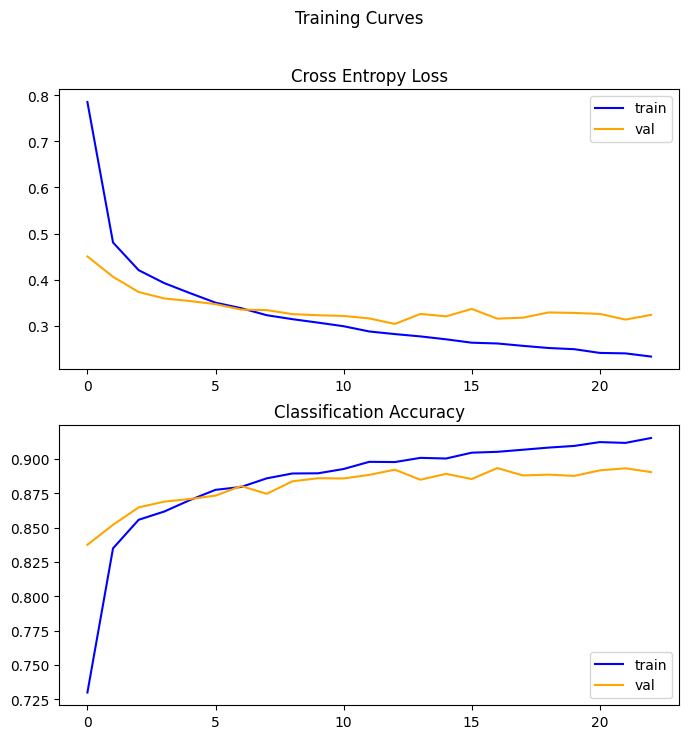

In [ ]:
summarize_diagnostics(history_mlp).show()

We notice how the curves for the training and validation steps develop in parallel indicating that no overfitting takes place. That means our model reguralizes relatively well and we should expect a similar performance to the test dataset.

We move on to evaluation of the model:

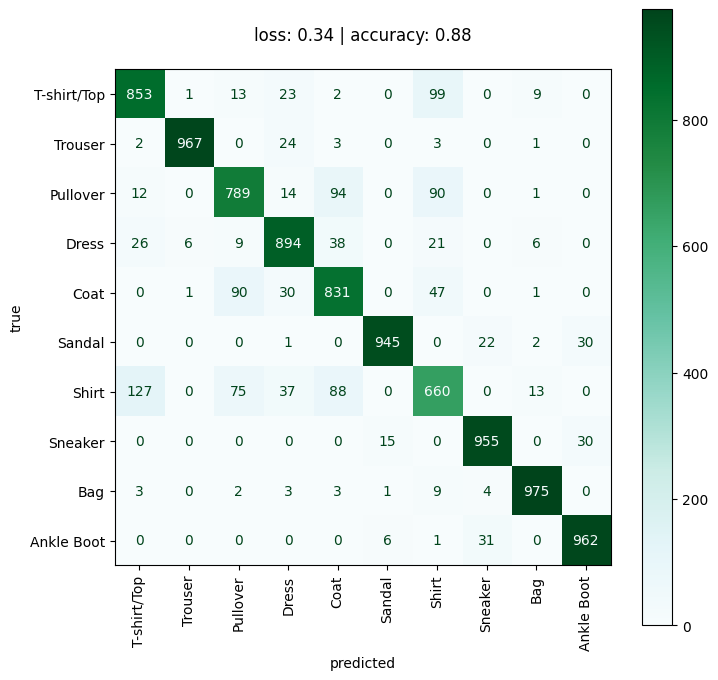

In [ ]:
# predicting and confusion matrix
loss_mlp, accuracy_mlp = mlp_model_final.evaluate(test_opt, steps=test_images.shape[0]//BATCH_SIZE, verbose=0)

predict_mlp = mlp_model_final.predict(test_images, verbose=0)
predict_mlp_class = np.argmax(predict_mlp, axis=1)

conf_matrix = confusion_matrix(test_labels, predict_mlp_class)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
cm_display.plot(ax=ax, cmap='BuGn')
ax.set_title('loss: {} | accuracy: {}\n'.format(round(loss_mlp, 2), round(accuracy_mlp, 2)))
ax.set_xlabel('predicted')
ax.set_ylabel('true')
plt.xticks(rotation=90)
plt.show()

We notice how the confusion matrix indicates a good performance of the model. The diagonal is deeper colored than other matrix indices, indicating that the model distinguishes different clothing classes with roughly *90%* accuracy.

Most of the missclassifications are taking place in the following pairs:
- Shirts are getting confused with T-shirts/Tops
- Pullovers with Coats
- Pullovers with Shirts and vice verse

The best performed class in terms of precision are the Bags and Trousers in terms of recall.

### CNN Architecture
---

The model we are going to develop is inspired by [VGGNet](https://arxiv.org/abs/1409.1556), one of the earliest CNN architectures proposed to solve large image dataset problems. To avoid overfitting, dropout layers were added to the model's architecture, which randomly ignore a subset of layer outputs. The output layer is also set to 10 neurons, equal to the number of classes of the dataset:

In [ ]:
def build_cnn_model(layers):

  """
  Creates a CNN model for image classification.

  PARAMETERS
      @ layers:
        if zero, whenever a Convoluation layer takes place, only one instance is added
        if one,  whenever a Convoluation layer takes place, two instances are added

  RETURNS
      a tf.keras.Sequential model

  """

  cnn = tf.keras.Sequential()

  cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
  if layers:
    cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
  cnn.add(tf.keras.layers.MaxPooling2D((2, 2)))

  cnn.add(tf.keras.layers.Dropout(0.10))

  cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  if layers:
    cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  cnn.add(tf.keras.layers.MaxPooling2D((2, 2)))

  cnn.add(tf.keras.layers.Dropout(0.15))

  cnn.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  if layers:
    cnn.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  cnn.add(tf.keras.layers.MaxPooling2D((2, 2)))

  cnn.add(tf.keras.layers.Dropout(0.20))

  cnn.add(tf.keras.layers.Flatten())

  cnn.add(tf.keras.layers.Dense(64, activation='relu'))

  cnn.add(tf.keras.layers.Dropout(0.25))

  cnn.add(tf.keras.layers.Dense(32, activation='relu'))

  cnn.add(tf.keras.layers.Dense(10, activation='softmax'))

  cnn.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
  )

  return cnn

We will `GridSearch` over the above architecture for *10* epochs to find the best combination of:

- layers
- batch size

Regarding the layers, we will check whether consecutive convolutions enable a better performance over just a single one:

In [ ]:
# grid search for CNN
cnn_model_grid = KerasClassifier(model=build_cnn_model, epochs=10, verbose=1)

param_grid = {
    'batch_size': [32, 64, 128],
    'model__layers': [0, 1]
}

grid = GridSearchCV(estimator=cnn_model_grid, param_grid=param_grid, n_jobs=-1, cv=5)

grid_result = grid.fit(train_images, train_labels)

Epoch 1/10
1500/1500 [==============================] - 12s 5ms/step - loss: 0.6560 - accuracy: 0.7560
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3799 - accuracy: 0.8628
Epoch 3/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3179 - accuracy: 0.8856
Epoch 4/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2836 - accuracy: 0.8978
Epoch 5/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2594 - accuracy: 0.9047
Epoch 6/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2451 - accuracy: 0.9123
Epoch 7/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2291 - accuracy: 0.9173
Epoch 8/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2168 - accuracy: 0.9223
Epoch 9/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2094 - accuracy: 0.9232
Epoch 10/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.20

The best combination results in:

In [ ]:
# best parameter combination
for key,value in grid_result.best_params_.items():
  print(key, value)

batch_size 32
model__layers 1


We will use these parameters to train our model for 100 epochs. Following the MLP model, we will also take utilize the `EarlyStopping` callback:

In [ ]:
# data preparation
BATCH_SIZE = 32

train_opt =_input_fn(train_images, train_labels, BATCH_SIZE)
val_opt =_input_fn(val_images, val_labels, BATCH_SIZE)
test_opt =_input_fn(test_images, test_labels, BATCH_SIZE)

cnn_model_final = build_cnn_model(layers=1)

# callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# training
history_cnn = cnn_model_final.fit(
    train_opt,
    validation_data = val_opt,
    epochs = 100,
    batch_size = BATCH_SIZE,
    steps_per_epoch = train_images.shape[0]//BATCH_SIZE,
    validation_steps = val_images.shape[0]//BATCH_SIZE,
    callbacks = [early_stopping]
)

Epoch 1/100
1500/1500 [==============================] - 12s 6ms/step - loss: 0.6197 - accuracy: 0.7707 - val_loss: 0.3722 - val_accuracy: 0.8568
Epoch 2/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3628 - accuracy: 0.8681 - val_loss: 0.3286 - val_accuracy: 0.8817
Epoch 3/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3092 - accuracy: 0.8886 - val_loss: 0.2764 - val_accuracy: 0.8987
Epoch 4/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2744 - accuracy: 0.9024 - val_loss: 0.2586 - val_accuracy: 0.9042
Epoch 5/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2533 - accuracy: 0.9086 - val_loss: 0.2672 - val_accuracy: 0.9045
Epoch 6/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2343 - accuracy: 0.9152 - val_loss: 0.2317 - val_accuracy: 0.9166
Epoch 7/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2191 - accuracy: 0.9210 - val_loss: 0.2247 - val_a

We will visualize the performance of the training and validation sets:

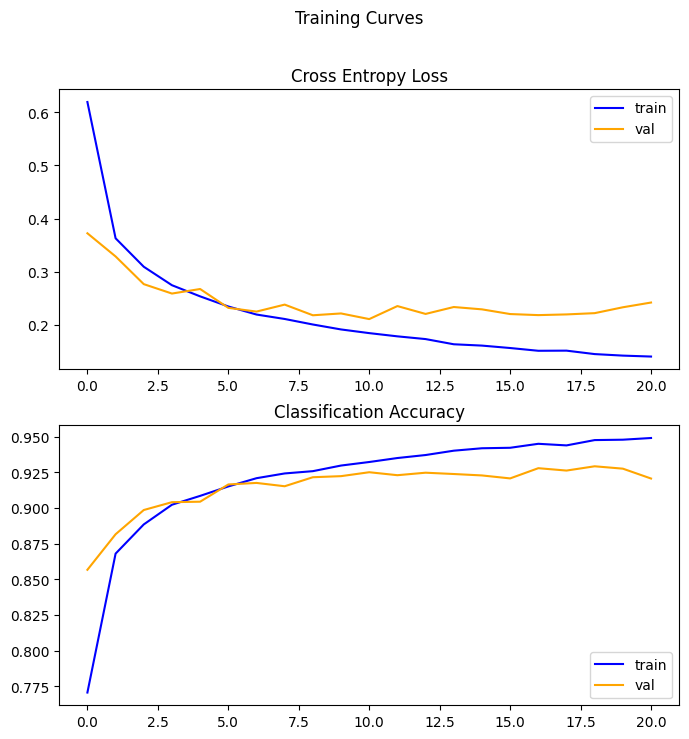

In [ ]:
summarize_diagnostics(history_cnn).show()

We notice that the curves start to deviate from one another displaying early signs of overfitting. Moving on the evaluation of the model we have:

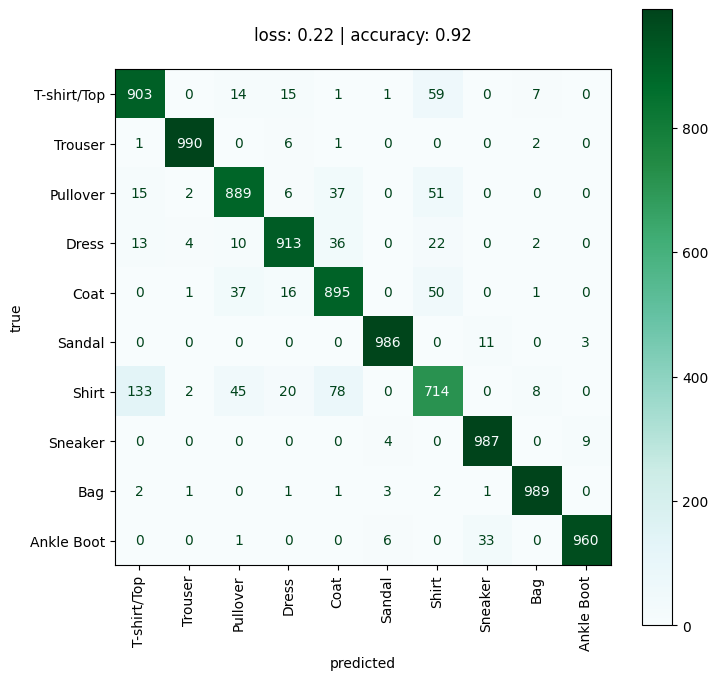

In [ ]:
# predicting and confusion matrix
loss_cnn, accuracy_cnn = cnn_model_final.evaluate(test_opt, steps=test_images.shape[0]//BATCH_SIZE, verbose=0)

predict_cnn = cnn_model_final.predict(test_images, verbose=0)
predict_cnn_class = np.argmax(predict_cnn, axis=1)

conf_matrix = confusion_matrix(test_labels, predict_cnn_class)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
cm_display.plot(ax=ax, cmap='BuGn')
ax.set_title('loss: {} | accuracy: {}\n'.format(round(loss_cnn, 2), round(accuracy_cnn, 2)))
ax.set_xlabel('predicted')
ax.set_ylabel('true')
plt.xticks(rotation=90)
plt.show()

We notice a slight increase in the performance comparing the CNN architecture to the Multi-Layer one. The accuracy is *92%* compared to *89%*. It is worth noting that the training of the CNN took nearly 4-times as much as the MLP one, potentially deemming the performance increase inadequate.

It is worth noting that the model has difficulties distinguishing the same pairs as the MLP model:
- Shirts and T-shirts/Tops
- Shirts and Coats
- Pullovers and Shirts

The best performance class are now Trousers, in both precision and recall.

## Conclusion & Final Thoughts
---

Two different architectures of Neural Networks were developed on the MNIST fashion dataset: MLP and CNN.

In both models `GridSearch` was utilized to reach the best combination of batch size and hidden layers of the networks. More time is worth investing in this step, adding to the parameters the optimizer, the learning rate of the optimizer and the dropout rate. Such searches, however, only make sense for a large number of epochs, meaning that they are time consuming.

The Multi-Layer Perceptron network reached a *89%* accuracy, slighlty worse than the Convolutional Neural Network's *92%*.

In terms of both models, data augmentation was utilized. Given, however, the state of the dataset, rotating, shifting or zooming on images did not seem to enable a better performance, rather than the opposite. Clothing is presented in a certain manner and angle, meaning that the model does not gain much knowledge looking at the images from any different setting.

The difference in the training times and performance of the models deems the first one as the most effective one, since it's cheaper in terms of time and computational power.